In [1]:
'''
    I am learning GANs using PyTorch.
    Thanks to tutorial of Dev Nag.
    This example of GANs in Pytorch is from
    https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f
'''

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
# Data params
data_mean = 4
data_stddev = 1.25

In [34]:
# Model params
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 50   # Generator complexity
g_output_size = 1    # size of generated output vector
d_input_size = 100   # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
minibatch_size = d_input_size

d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4

optim_betas = (0.9, 0.999)

num_epochs = 50000

print_interval = 200
plot_interval = 200

d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

In [35]:
# ### Uncomment only one of these
#(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)

In [36]:
# ##### DATA: Target data and generator input data

def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

In [37]:

# ##### MODELS: Generator model and discriminator model

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return F.sigmoid(self.map3(x))

In [38]:
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)

In [39]:
d_sampler = get_distribution_sampler(data_mean, data_stddev)
gi_sampler = get_generator_input_sampler()

In [40]:
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)

In [41]:
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

In [42]:
g_current_loss = 0
g_all_losses = []

d_curr_real_loss = 0
d_all_real_losses = []

d_curr_fake_loss = 0
d_all_fake_losses = []

for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        d_real_data = Variable(d_sampler(d_input_size))
        d_real_decision = D(preprocess(d_real_data))
        d_real_error = criterion(d_real_decision, Variable(torch.ones(1)))  # ones = true
        d_curr_real_loss += d_real_error.data[0]
        d_real_error.backward() # compute/store gradients, but don't change params

        #  1B: Train D on fake
        d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
        d_fake_decision = D(preprocess(d_fake_data.t()))
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1)))  # zeros = fake
        d_curr_fake_loss += d_fake_error.data[0]
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

    for g_index in range(g_steps):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        G.zero_grad()

        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        g_fake_data = G(gen_input)
        dg_fake_decision = D(preprocess(g_fake_data.t()))
        g_error = criterion(dg_fake_decision, Variable(torch.ones(1)))  # we want to fool, so pretend it's all genuine
        g_current_loss += g_error.data[0]
        
        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters

    if epoch % print_interval == 0:
        print("Epoch = %d" % epoch)
        print("Discriminator error (real / fake): %.4f/%.4f" % (d_real_error.data[0], d_fake_error.data[0]))
        print("Generator error: %.4f" % g_error.data[0])
        print("Real [Mean, Standar Deviation]: [%.4f, %.4f]" % (d_real_data.data.mean(), d_real_data.data.std()))
        print("Fake [Mean, Standar Deviation]: [%.4f, %.4f]\n" % (d_fake_data.data.mean(), d_fake_data.data.std()))

        
    if epoch % plot_interval == 0:
        g_all_losses.append(g_current_loss / plot_interval)
        g_current_loss = 0
        
        d_all_real_losses.append(d_curr_real_loss / plot_interval)
        d_curr_real_loss = 0
        
        d_all_fake_losses.append(d_curr_fake_loss / plot_interval)
        d_curr_fake_loss = 0
        
print("\nTraining completed\n")

Epoch = 0
Discriminator error (real / fake): 0.4876/0.7192
Generator error: 0.6635
Real [Mean, Standar Deviation]: [3.7839, 1.1535]
Fake [Mean, Standar Deviation]: [0.2958, 0.0119]

Epoch = 200
Discriminator error (real / fake): 0.0000/0.1691
Generator error: 1.8881
Real [Mean, Standar Deviation]: [3.6607, 1.1784]
Fake [Mean, Standar Deviation]: [-0.4654, 0.0109]

Epoch = 400
Discriminator error (real / fake): 0.0000/0.1388
Generator error: 2.0812
Real [Mean, Standar Deviation]: [4.0631, 1.3301]
Fake [Mean, Standar Deviation]: [-0.4829, 0.0042]

Epoch = 600
Discriminator error (real / fake): 0.0000/0.0658
Generator error: 2.8064
Real [Mean, Standar Deviation]: [3.9284, 1.0734]
Fake [Mean, Standar Deviation]: [-0.4954, 0.0183]

Epoch = 800
Discriminator error (real / fake): -0.0000/0.0473
Generator error: 3.1285
Real [Mean, Standar Deviation]: [4.1278, 1.4262]
Fake [Mean, Standar Deviation]: [-0.4990, 0.0745]

Epoch = 1000
Discriminator error (real / fake): 0.0000/0.1484
Generator error

<IPython.core.display.Javascript object>


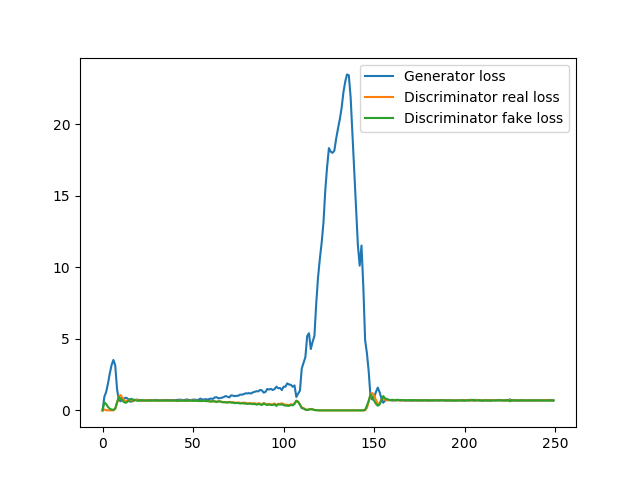

In [43]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(g_all_losses, label="Generator loss")

# plt.figure()
plt.plot(d_all_real_losses, label="Discriminator real loss")

# plt.figure()
plt.plot(d_all_fake_losses, label="Discriminator fake loss")
plt.legend()